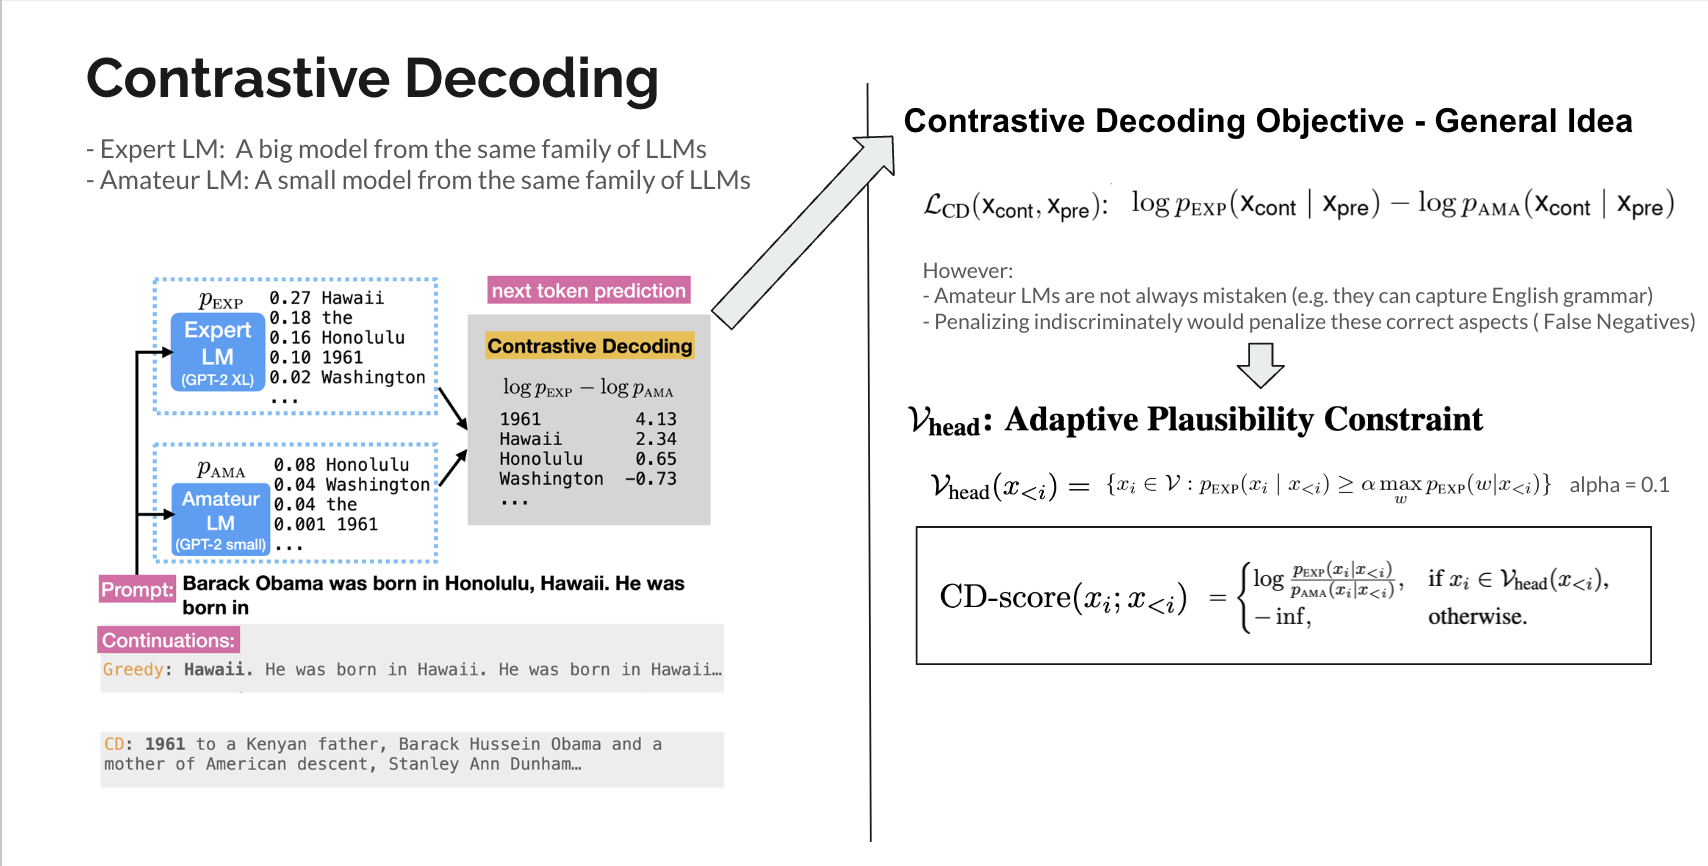

In [ ]:
import torch
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained('gpt2')
amateur_lm = transformers.AutoModelForCausalLM.from_pretrained('gpt2')
expert_lm = transformers.AutoModelForCausalLM.from_pretrained('gpt2-medium')

encoding = tokenizer("Hello world", return_tensors='pt')
logits = expert_lm(**encoding).logits

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
print(logits.shape)

torch.Size([1, 2, 50257])


In [ ]:
encoding

{'input_ids': tensor([[15496,   995]]), 'attention_mask': tensor([[1, 1]])}

In [ ]:
import torch.nn.functional as F

def generate_next_token(encoding, expert_model, amateur_model, num_tokens):
  generated_tokens = encoding['input_ids'][0].tolist()

  for _ in range(num_tokens):
    with torch.no_grad():
      expert_logits = expert_model(**encoding).logits[0, -1, :]
      amateur_logits = amateur_model(**encoding).logits[0, -1, :]

      expert_probs = F.softmax(expert_logits, dim=-1)
      amateur_probs = F.softmax(amateur_logits, dim=-1)

      #calculate contrastive decoding scores - NO adaptive plausability yet
      contrastive_logits = torch.log(expert_probs) - torch.log(amateur_probs)

      #sampling
      next_token_probs = F.softmax(contrastive_logits, dim=-1)
      next_token = torch.argmax(contrastive_logits, dim=-1)
      print(next_token.item())

      generated_tokens.append(next_token.item())
      text = tokenizer.decode(generated_tokens)
      encoding = tokenizer(text, return_tensors='pt')

  return tokenizer.decode(generated_tokens)

In [ ]:
print(generate_next_token(encoding, expert_lm, amateur_lm, 5))

35343
10108
26534
14818
35266
Hello world/** simultane�� Sud�


In [ ]:
import torch.nn.functional as F

def calculate_vhead(expert_probs, alpha):
  mask = expert_probs >= (alpha * torch.max(expert_probs))
  return mask

def generate_next_token(encoding, expert_model, amateur_model, num_tokens, alpha = 0.1):
  generated_tokens = encoding['input_ids'][0].tolist()

  for _ in range(num_tokens):
    with torch.no_grad():
      expert_logits = expert_model(**encoding).logits[0, -1, :]
      amateur_logits = amateur_model(**encoding).logits[0, -1, :]

      expert_probs = F.softmax(expert_logits, dim=-1)
      amateur_probs = F.softmax(amateur_logits, dim=-1)

      #binary mask for plausible tokens
      plausible_mask = calculate_vhead(expert_probs, alpha)
      contrastive_logits = torch.log(expert_probs)
      amateur_penalty = torch.log(amateur_probs)

      #CD score
      contrastive_logits[plausible_mask] -= amateur_penalty[plausible_mask]
      contrastive_logits[~plausible_mask] = float('-inf')

      #sampling
      next_token_probs = F.softmax(contrastive_logits, dim=-1)
      next_token = torch.argmax(contrastive_logits, dim=-1)
      print(next_token.item())

      generated_tokens.append(next_token.item())
      text = tokenizer.decode(generated_tokens)
      encoding = tokenizer(text, return_tensors='pt')

  return tokenizer.decode(generated_tokens)


In [ ]:
print(generate_next_token(encoding, expert_lm, amateur_lm, 5))

6
379
262
886
13
Hello world' at the end.
